<a href="https://colab.research.google.com/github/KMeirazhdinov/Quantitative-Finance-project/blob/main/Option_pricing_and_delta_hedging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What this file does: 


1.   Calculates call/put option prices using Black-Scholes formula
2.   Calculates the delta of the call/put option using the closed form solution and using the Monte Carlo simulations. 
3.   Delta hedges the portfolio
4.   Performes Euler approximation of the stock price evolution. 



In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from ipywidgets import widgets, fixed
import matplotlib.pyplot as plt

Class Black_Scholes creates objects that represent a certain risky asset using the several parameters. Parameters will be shown later. 

The procedure is as follows: 



1.   Generate paths of the Brownian motion for the corresponding time grid. Method name - "Brownian_motion()".

2.   Calculate the Stock prices for the corresponding time grid. For the Black-Scholes by default we calculate the stock price under the risk neutral measure Q. However, mean return of the risky asset can be used as input. Method name - "Stock_price()".

3.   Calculate d1 and d2 parameters required for the formula. Method name - "d1_d2_parameters()".

4.   Calculate the price of the call/put option using the Black-Scholes formula. Method name - option_pricing().

5.   Calculate the delta of the put/call option using the exact formula and/or using the different methods such as "Bump and reprice with common numbers", "Path-wise method" and "Likelihood ratio method". Small change "h" that is used for the derivative approximation can be picked manually. As well as the number of Monte-Carlo simulation. (The more the better). Method name for exact calculation - "delta()" and for the approximations - "delta_approximate(h, m)".

6.   Since we use the self financing portfolio we can derive sample paths of the stock and money market account positions. Method name - "self_financing_sample_path()" .

7.   Self financing delta hedging of the portfolio. Method name - "hedge(trading_step, number of options, number of hedging simulations, initial bond price, option type put or call)".



In [ ]:
class Black_Scholes:
    
    def __init__(self, T_, mu_, sigma_, s0_, r_, K_, step_size_):
        
        self.T = T_
        self.mu = mu_
        self.sigma = sigma_
        self.s0 = s0_
        self.r = r_
        self.K = K_
        self.step_size = step_size_
        self.W = None
        
    def Brownian_motion(self, n, hedging = False):
        
        self.grid = np.arange(0, T + self.step_size, self.step_size)
        self.grid_modified = np.flip(self.grid[1:])
        if n != 1:

            increments = np.sqrt(self.step_size) * norm.rvs(size = [n, len(self.grid) - 1])
            W_holder = np.cumsum(increments, axis = 1)
            W_ = [[0]*len(self.grid)]*n
            for i in range(0, n):
                W_[i] = np.insert(W_holder[i], 0, 0)

        else:

            increments = np.sqrt(self.step_size) * norm.rvs(size = len(self.grid) - 1)
            W_ = np.cumsum(increments)
            W_ = np.insert(W_, 0, 0)
            
        if hedging:

            self.W_hedging = W_
            return self.W_hedging, self.grid, self.grid_modified

        else: 

            self.W = W_
        
    def get_Brownian_motion(self):

        return self.W
    
    def Stock_price(self, parameter, hedging = False):

        if hedging:

            S_ = self.s0 * np.exp((parameter - 0.5 * self.sigma ** 2) * self.grid + np.multiply(self.sigma, self.W_hedging)) #if parameter = r, then risk neutral measure
            self.S_hedging = S_
            return self.S_hedging

        else: 

            S_ = self.s0 * np.exp((parameter - 0.5 * self.sigma ** 2) * self.grid + np.multiply(self.sigma, self.W))
            self.S = S_

    def get_Stock_price(self):

        return self.S

    def euler_approximation(self, Euler_step_size):

        refinement = np.arange(0, len(self.grid), Euler_step_size / self.step_size)

        self.euler_grid = [0]

        self.S_euler = np.zeros((len(refinement),))

        self.S_euler[0] = self.s0

        for t in range(0, len(refinement)-1):

            self.euler_grid.append(self.grid[int(refinement[t+1])])

            self.S_euler[t+1] = self.S_euler[t] + self.r*self.S_euler[t] * Euler_step_size + self.sigma*self.S_euler[t]*(self.W[int(refinement[t+1])]-self.W[int(refinement[t])])


    def get_euler_approximation(self):

        return self.S_euler, self.euler_grid, self.grid

    def d1_d2_parameters(self, hedging = False):

        def parameters(self, stock):

            if np.ndim(stock) != 1:

                d1_ = (np.log(stock[:,:len(self.grid_modified)]/self.K) + (self.r + 0.5*self.sigma**2)*(self.grid_modified)) / (self.sigma*np.sqrt(self.grid_modified))
                d2_ = d1_ - self.sigma*np.sqrt(self.grid_modified)

            else: 

                d1_ = (np.log(stock[:len(stock)-1]/self.K) + (self.r + 0.5*self.sigma**2)*(self.grid_modified)) / (self.sigma*np.sqrt(self.grid_modified))
                d2_ = d1_ - self.sigma*np.sqrt(self.grid_modified)

            return d1_,d2_

        if hedging:
            self.d1_hedging, self.d2_hedging = parameters(self,self.S_hedging)
            return self.d1_hedging, self.d2_hedging

        else: 
            self.d1, self.d2 = parameters(self,self.S)


    def get_d1_d2_parameters(self):

        return self.d1,self.d2


    def option_pricing(self, hedging = False):
    
        def opt(self,d1,d2,stock):
            if np.ndim(stock) == 1:

                P_ = self.K * np.multiply(np.exp(-self.r*self.grid_modified),norm.cdf(-d2)) - np.multiply(stock[:len(stock)-1],norm.cdf(-d1))
                C_ = stock[:len(stock)-1]*norm.cdf(d1,0,1) - self.K*np.exp(-self.r*self.grid_modified)*norm.cdf(d2,0,1)
            else: 

                P_ = self.K * np.multiply(np.exp(-self.r*self.grid_modified),norm.cdf(-d2)) - np.multiply(stock[:,:len(self.grid_modified)],norm.cdf(-d1))
                C_ = stock[:,:len(self.grid_modified)]*norm.cdf(d1,0,1) - self.K*np.exp(-self.r*self.grid_modified)*norm.cdf(d2,0,1)

            return P_,C_

        if hedging:
            self.P_hedging,self.C_hedging = opt(self,self.d1_hedging,self.d2_hedging,self.S_hedging)
            return self.P_hedging,self.C_hedging
        else:
            self.P,self.C = opt(self,self.d1,self.d2,self.S)

    def get_option_price(self,time):
        
        if len(np.shape(self.W)) == 1:
            
            return "Put option price = {}, Call option price = {}".format(self.P[time],self.C[time])
        
        else:
            return "Put option price = {}, Call option price = {}".format(np.mean(self.P[:,time]),np.mean(self.C[:,time]))

    def delta(self, hedging = False):
        
        if hedging: 

            self.delta_put_hedging = -norm.cdf(-self.d1_hedging)
            self.delta_call_hedging = norm.cdf(self.d1_hedging)
            return self.delta_put_hedging,self.delta_call_hedging
        else:

            self.delta_put = -norm.cdf(-self.d1)
            self.delta_call = norm.cdf(self.d1)

        
    
    def get_delta(self,time):
        
        if len(np.shape(self.W)) == 1:
            
            return "Delta of the put option: {}, delta of the call option: {}".format(self.delta_put[time], self.delta_call[time])
        
        else:
            
            return "Delta of the put option: {}, delta of the call option: {}".format(np.mean(self.delta_put[:,time]), np.mean(self.delta_call[:,time]))

    def delta_approximate(self, h, m):
        
        # Delta approximation for time = 0.
        
        # 1.Bump and reprice method with common numbers
         
        W_T = np.sqrt(T)*norm.rvs(size = m, random_state=None)
        S_T = self.s0*np.exp((self.r-0.5*self.sigma**2)*self.T+self.sigma*W_T)
        S_T_h = (self.s0+h)*np.exp((self.r-0.5*self.sigma**2)*self.T+self.sigma*W_T)
        
        # Put
        P_T = np.clip(self.K-S_T, 0, np.inf)
        P_T_h = np.clip(self.K-S_T_h, 0, np.inf)
        proxyprice = np.exp(-self.r*self.T)*np.mean(P_T)
        proxyprice_h = np.exp(-self.r*self.T)*np.mean(P_T_h)
        self.delta_put_BR_C = (proxyprice_h - proxyprice)/h
        
        # Call 
        C_T = np.clip(S_T-self.K, 0, np.inf)
        C_T_h = np.clip(S_T_h-self.K, 0, np.inf)
        proxyprice_c = np.exp(-self.r*self.T)*np.mean(C_T)
        proxyprice_h_c = np.exp(-self.r*self.T)*np.mean(C_T_h)
        self.delta_call_BR_C = (proxyprice_h_c - proxyprice_c)/h
        
        
        
        # 2.Path-wise method
    
        S_T = self.s0 * np.exp((self.r-0.5*self.sigma**2) + self.sigma * np.sqrt(self.T) * norm.rvs(size = m, random_state=None))
        
        # Put 
        input_delta_pathwise = -np.exp((self.r-0.5*self.sigma**2)*self.T+self.sigma*np.sqrt(self.T)*norm.rvs(0,1))*np.where(S_T < self.K, 1, 0)
        self.delta_put_pathwise = np.exp(-self.r*self.T)*np.mean(input_delta_pathwise)
        
        # Call 
        input_delta_pathwise_call = np.exp((self.r-0.5*self.sigma**2)*self.T+self.sigma*np.sqrt(self.T)*norm.rvs(0,1))*np.where(S_T > self.K, 1, 0)
        self.delta_call_pathwise = np.exp(-self.r*self.T)*np.mean(input_delta_pathwise_call)


    
        # 3.Likelihood ratio method
        
        delta_all_LRM = [0]*m
        delta_all_LRM_call = [0]*m
        
        for i in range(0, m-1):

            S_T = self.s0*np.exp((self.r-0.5*self.sigma**2)+self.sigma*np.sqrt(self.T)*norm.rvs())

            delta_all_LRM[i] = np.clip(self.K-S_T, 0, np.inf)*(np.log(S_T/self.s0)-(self.r-0.5*self.sigma**2)*self.T)/((self.sigma**2)*self.T*self.s0)
            delta_all_LRM_call[i] = np.clip(S_T-K, 0, np.inf)*(np.log(S_T/s0)-(r-0.5*sigma**2)*T)/((sigma**2)*T*s0)
            
        self.delta_put_LRM = np.exp(-self.r*self.T)*np.mean(delta_all_LRM)
        self.delta_call_LRM = np.exp(-r*T)*np.mean(delta_all_LRM_call)
       
    def get_delta_approximate(self,option):
        
        if option.lower() == "put":
        
            return "Put option => Bump and reprice with common numbers: {} \nPath-wise method: {} \nLikelihood ratio method: {}".format(self.delta_put_BR_C,self.delta_put_pathwise,self.delta_put_LRM)
        
        elif option.lower() == "call":
            
            return "Call option => Bump and reprice with common numbers: {} \nPath-wise method: {} \nLikelihood ratio method: {}".format(self.delta_call_BR_C,self.delta_call_pathwise,self.delta_call_LRM)
        
    def self_financing_sample_path(self):
        
        self.phi_sf = self.delta_put
        self.B = np.exp(self.r * self.grid)
        self.psi_sf = (self.P - self.phi_sf * self.S[:len(self.S)-1]) / self.B[:len(self.B)-1]
        self.Value_replicating_portfolio_sf = self.phi_sf * self.S[:len(self.S)-1] + self.psi_sf * self.B[:len(self.B)-1]
        
    def get_self_financing_sample_path(self):
        
        return self.phi_sf,self.psi_sf,self.Value_replicating_portfolio_sf
      
    
    def hedge(self, trading_step_, option_number_, N_, B0_,option_type):

        self.trading_step = trading_step_
        self.option_number = option_number_
        self.N = N_
        self.B0 = B0_
        hedging = True

        def trade(self, trade_grid,delta,option):

            self.psi = np.zeros([self.N, len(trade_grid)]) 
            self.phi = np.zeros([self.N, len(trade_grid)]) 
            self.phi[:,0] = -1 * (self.option_number) * delta[:,0]
            available = (-self.option_number)*option[:,0]
            self.psi[:,0] = (available - self.phi[:,0]*self.S_hedging[:,0]) / self.B[0]

            for i in range(0,self.N-1):
                
                for t in range(1, len(trade_grid)): 
                    
                    trade_time = np.where(self.grid == trade_grid[t])[0][0]
                    delta_t = delta[i,trade_time]
                    available = self.phi[i,t-1]*self.S_hedging[i,trade_time] + self.psi[i,t-1]*self.B[trade_time]
                    self.phi[i,t] = (-1)*(self.option_number)* delta_t
                    self.psi[i,t] = (available - self.phi[i,t]*self.S_hedging[i,trade_time]) / self.B[trade_time]


        W,self.grid,self.grid_modified = Black_Scholes.Brownian_motion(self,self.N,hedging)
        self.S_hedging = Black_Scholes.Stock_price(self, self.r,hedging)
        self.B = self.B0*np.exp(self.r * self.grid)
        trade_grid = np.arange(0, self.T, self.trading_step)
        d1, d2 = Black_Scholes.d1_d2_parameters(self,hedging)
        P, C = Black_Scholes.option_pricing(self,hedging)
        delta_put, delta_call = Black_Scholes.delta(self,hedging)
        
        if option_type.lower() == "put":
            trade(self, trade_grid, delta_put, P)
        else:
            trade(self, trade_grid, delta_call, C)


    def performance(self):
        
        self.V_T = self.phi[:,-1]*self.S_hedging[:,-1] + self.psi[:,-1]*self.B[-1]
        self.C_T = (-self.option_number)*np.clip(self.K-self.S_hedging[:,-1], 0, np.inf)
        self.Liability = self.V_T - self.C_T
        self.mean_liability = np.mean(self.Liability)
        self.std_liability = np.std(self.Liability)

        output = "Mean liability = {} \nStandard deviation of the liability = {}".format(self.mean_liability,self.std_liability)
        print(output)

        return self.V_T,self.C_T



Initialize the parameters.

In [ ]:
T = 1               # Time of option expiration
step_size = 0.001   # Step size in the time grid
mu = 0.6            # The drift rate of the risky asset S
sigma = 0.2         # standard deviation of the risky asset S
K = 90              # Strike price
s0 = 100            # Initial price of the risky asset S
r = 0.01            # Interest rate           # Initial Bond price           # Number of simulations

First, generate all the necessary information by calling the following functions.

In [ ]:
%%capture

Stock_1 = Black_Scholes(T, mu, sigma, s0, r, K, step_size)

#############################
Number_of_simulations = 1
#############################

Stock_1.Brownian_motion(Number_of_simulations)

Stock_1.Stock_price(r)

Stock_1.d1_d2_parameters()

Stock_1.option_pricing()

Stock_1.delta()

############################
small_change = 0.001 # Small change for the derivative approximation 
MC_simulations = 10000 # Number of Monte Carlo simulations for the approximation of the delta
############################

Stock_1.delta_approximate(small_change, MC_simulations)

Stock_1.self_financing_sample_path()


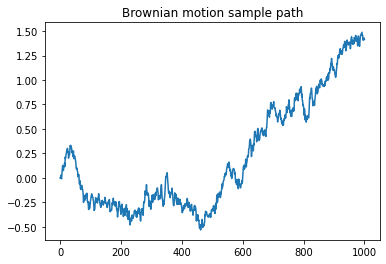

In [ ]:
plt.plot(Stock_1.get_Brownian_motion())
plt.title('Brownian motion sample path')
plt.show()

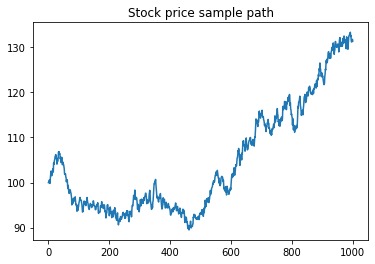

In [ ]:
plt.plot(Stock_1.get_Stock_price())
plt.title('Stock price sample path')
plt.show()

The following next 2 cells, perform the Euler approximation of the Stock price under the neutral measure Q. 

In [ ]:
%%capture
euler_step = 0.1
Stock_1.euler_approximation(euler_step) 

Text(0.5, 1.0, 'Euler Approximation with Euler step = 0.1')

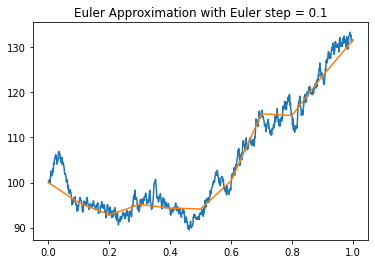

In [ ]:
S_euler, euler_grid, grid = Stock_1.get_euler_approximation()
plt.plot(grid, Stock_1.get_Stock_price(), label = "Exact simulation")
plt.plot(euler_grid, S_euler, label = "Euler approximation")
plt.title('Euler Approximation with Euler step = {}'.format(euler_step))

In [ ]:
print(Stock_1.get_delta(0))

Delta of the put option: -0.24926561103492134, delta of the call option: 0.7507343889650786


In [ ]:
print(Stock_1.get_delta_approximate('Put'))

print("\n" + Stock_1.get_delta_approximate('call'))

Put option => Bump and reprice with common numbers: -0.2426280785559065 
Path-wise method: -0.30062137661624383 
Likelihood ratio method: -0.24710283145656006

Call option => Bump and reprice with common numbers: 0.7595539953957342 
Path-wise method: 0.575266067408347 
Likelihood ratio method: 0.7421444275936804


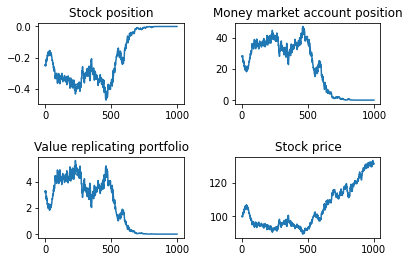

In [ ]:
stock_position, money_market_position, Value_replicating_portfolio = Stock_1.get_self_financing_sample_path()

figure, axis = plt.subplots(2, 2)
  
axis[0, 0].plot(stock_position)
axis[0, 0].set_title("Stock position")

axis[0, 1].plot(money_market_position)
axis[0, 1].set_title("Money market account position")

axis[1, 0].plot(Value_replicating_portfolio)
axis[1, 0].set_title("Value replicating portfolio")

axis[1, 1].plot(Stock_1.get_Stock_price())
axis[1, 1].set_title("Stock price")

figure.tight_layout(pad = 2.0)

plt.show()

Delta hedging the portfolio.

1.   N - number of hedging simulations 
2.   trading_step - readjustments at a time grid with stepsize 



In [ ]:
%%capture
############################
N = 1000 
trading_step = 0.002 
number_of_options = -1000
B0 = 1
option_type = "Put"
############################

Stock_1.hedge(trading_step, number_of_options, N, B0, option_type)
Stock_1.performance()

Mean liability = -1.875445411817578 
Standard deviation of the liability = 282.75674967670415


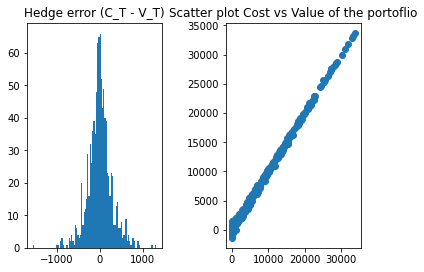

In [ ]:
Value_portfolio, Cost = Stock_1.performance()


figure, axis = plt.subplots(1, 2)
  
axis[0].hist(Cost - Value_portfolio,bins = 100)
axis[0].set_title("Hedge error (C_T - V_T)")

axis[1].scatter(Cost, Value_portfolio)
axis[1].set_title("Scatter plot Cost vs Value of the portoflio")

figure.tight_layout(pad = 1.5)

plt.show()